# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 3 - Mapas de Kohonen

Estudante: Paloma Sette

In [1]:
!git clone https://github.com/mdrs-thiago/minisom
import os 
os.chdir('minisom')

fatal: destination path 'minisom' already exists and is not an empty directory.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler, Normalizer, RobustScaler


from minisom.minisom import MiniSom

In [6]:
dataset = pd.read_csv(
    'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_breast_cancer.csv')

In [7]:
values = dataset.values[:,:-1]

## Parte 1 - Testando configurações

Nesta primeira etapa, iremos investigar como a configuração do mapa pode mudar de acordo com a escolha de parâmetros. 

##### 1. Escolha os parâmetros para o primeiro teste usando SOM. Para cada parâmetro, justifique sua escolha. Avalie o resultado.

**Parâmetros escolhidos**:

- **Tamanho do mapa (`m = 10, n = 10`)**  
  Escolhemos uma grade 10x10 para permitir que os grupos se distribuam com espaço suficiente, evitando sobreposição. É um tamanho intermediário, bom para começar a visualização sem granularidade excessiva.

- **Taxa de aprendizado na ordenação (`lr_ordering = 0.001`)**  
  Um valor pequeno, mas ainda eficaz para a fase inicial de ajuste dos pesos. Evita oscilações bruscas e permite que o SOM forme regiões estáveis.

- **Taxa no ajuste fino (`lr_finetuning = 0.0001`)**  
  Muito menor que a anterior, usada para pequenas correções nos pesos após a estrutura geral estar formada.

- **Função de decaimento (`decay_fcn`)**  
  Escolhemos um decaimento suave baseado em:
  $$new_{lr} = \frac{lr} {1 + 2 * \frac{t } {max_t}}$$
  Isso reduz gradualmente a influência das atualizações ao longo do tempo.

- **Topologia `"hexagonal"`**  
  A topologia hexagonal permite uma vizinhança mais fluida entre os neurônios, com mais conectividade do que a grade retangular.

- **Dataset**: `breast_cancer`  
  A base escolhida apresenta dados clínicos com atributos contínuos, ideal para observar agrupamentos naturais em dados de saúde.

**Avaliação dos resultados**:

O gráfico gerado das curvas de erro mostra:

- **Erro de quantização** (`quantization_error`):  
  Mede o quão distante, em média, cada vetor de entrada está do seu neurônio vencedor. Uma queda nessa curva indica que os neurônios estão se especializando bem.

- **Erro topográfico** (`topographic_error`):  
  Mede se os dois neurônios mais próximos do dado também são vizinhos no mapa. Quanto menor, melhor preservação topológica.

Durante a ordenação, os erros caem rapidamente, mostrando que o SOM está aprendendo.  
Durante o finetuning, os erros estabilizam em valores baixos, indicando que os ajustes finos foram bem-sucedidos.


In [9]:
#decay function 

def decay_fcn(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''

    new_lr = lr/(1 + 2*actual_t/max_t)

    return new_lr


m = 10 #Dimensão X do mapa de Kohonen
n = 10 #Dimensão Y do mapa de Kohonen
lr_ordering = 0.001 #Taxa de aprendizado - Ordering phase
lr_finetuning = 0.0001 #Taxa de aprendizado - Finetuning phase

topology = "hexagonal"

ordering_time = 1000 
finetuning_time = 10000 
decay_fun =  decay_fcn 


#Dimensão do vetor de entrada
input_len = values.shape[1]

X = minmax_scale(values)

In [10]:
som = MiniSom(m,n,input_len,learning_rate=lr_ordering,topology=topology,decay_function=decay_fcn)
som.pca_weights_init(X)

som.train_random(X, ordering_time, verbose=True)


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.9983446143068794


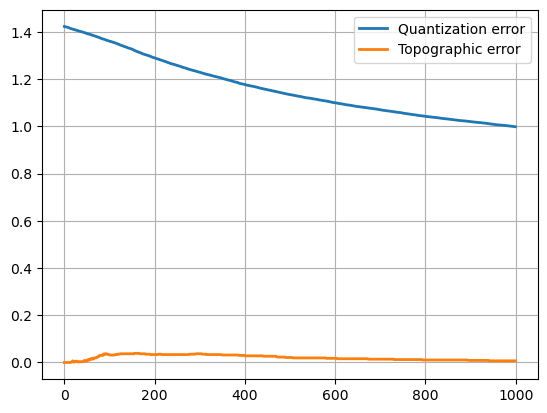

In [11]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

O gráfico mostra duas métricas fundamentais durante o treinamento da SOM:

- **Erro de quantização (linha azul):**  
  Houve uma queda progressiva ao longo das iterações, indicando que os neurônios estão se tornando mais próximos dos dados de entrada, ou seja, o mapa está se ajustando bem à distribuição dos dados.

- **Erro topográfico (linha laranja):**  
  Se manteve muito próximo de zero, o que é um excelente indicativo. Isso mostra que a vizinhança dos neurônios está sendo preservada: os dados semelhantes caem em neurônios vizinhos, mantendo a topologia do espaço original.

Esse comportamento sugere que os parâmetros escolhidos (tamanho do mapa, taxas de aprendizado, função de decaimento e topologia) foram adequados para a fase de ordenação. O mapa começa a se organizar de maneira coerente.

In [12]:
som._learning_rate = lr_finetuning #Para mudar a taxa de aprendizado durante o período de finetuning 

som.train_random(X, finetuning_time, verbose=True)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.798085746701451


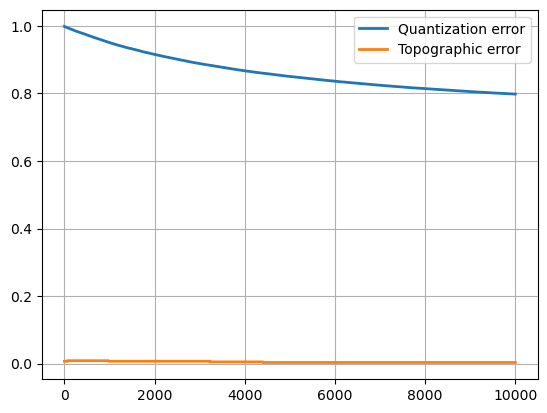

In [13]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

 **Análise da Fase de Ajuste Fino (Finetuning)**

Nesta etapa, a taxa de aprendizado foi reduzida para `lr_finetuning = 0.0001`, com o objetivo de realizar pequenos ajustes sobre o mapa já estruturado durante a fase de ordenação. Esse processo busca refinar os pesos sem desestabilizar a topologia previamente organizada.

- O **erro de quantização** continua em queda suave, evidenciando que o mapa está se especializando ainda mais para representar os dados com precisão. O valor final próximo de 0.80 indica boa representação vetorial.

- O **erro topográfico** manteve-se estável e praticamente nulo durante toda a fase. Isso demonstra que a estrutura topológica do SOM foi preservada, sem distorções na vizinhança dos neurônios.

O comportamento dos erros confirma que a estratégia de dois estágios — com taxas decrescentes e número adequado de iterações , foi eficaz para construir um mapa bem ajustado aos dados da base `c_breast_cancer`.


##### 2. Modifique a topologia da rede. Teste diferentes valores e avalie o resultado.

Aqui, podemos testar duas topologias com dois tamanhos diferentes de mapa. Por exemplo:

| Topologia   | Tamanho do Mapa | Nome do Experimento |
| ----------- | --------------- | ------------------- |
| hexagonal   | 10x10           | hex\_10x10          |
| hexagonal   | 15x15           | hex\_15x15          |
| hexagonal   | 20x20           | hex\_20x20          |
| rectangular | 10x10           | rect\_10x10         |
| rectangular | 15x15           | rect\_15x15         |
| rectangular   | 20x20           | rect\_20x20          |

Então, geramos o código para facilitar os testes:

In [15]:
def treinar_som(m, n, topology, nome):
     print(f"\n===> Executando {nome} <===")
     som = MiniSom(m, n, input_len,
                    learning_rate=lr_ordering,
                    topology=topology,
                    decay_function=decay_fcn)
     som.pca_weights_init(X)
     som.train_random(X, ordering_time, verbose=True)
     
     plt.plot(som._quantization_error, linewidth=2, label='Quantization error')
     plt.plot(som._topographic_error, linewidth=2, label='Topographic error')
     plt.title(f'{nome} - Ordering')
     plt.legend(); plt.grid(); plt.show()

     som._learning_rate = lr_finetuning
     som.train_random(X, finetuning_time, verbose=True)
     
     plt.plot(som._quantization_error, linewidth=2, label='Quantization error')
     plt.plot(som._topographic_error, linewidth=2, label='Topographic error')
     plt.title(f'{nome} - Finetuning')
     plt.legend(); plt.grid(); plt.show()
     
     return som


E agora podemos testar:


===> Executando hex_10x10 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.995386879531492


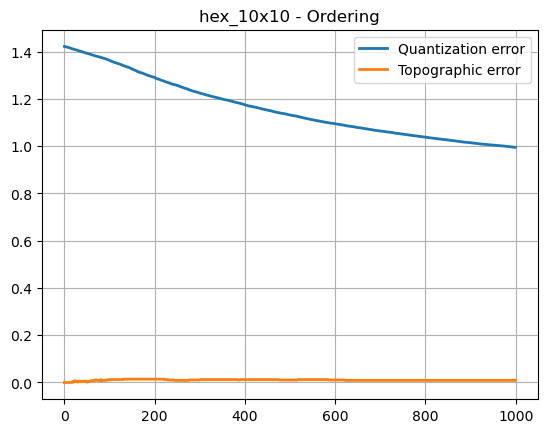

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7971032381234826


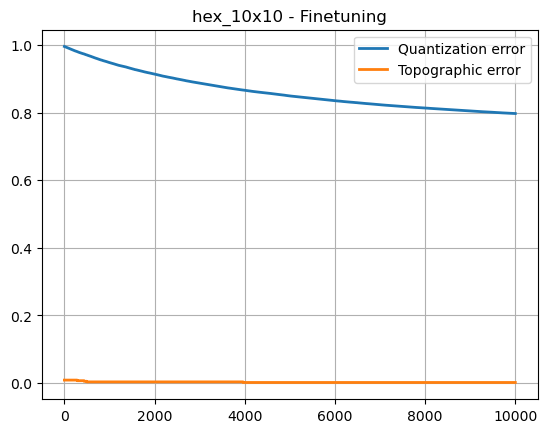


===> Executando hex_15x15 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0178906990433796


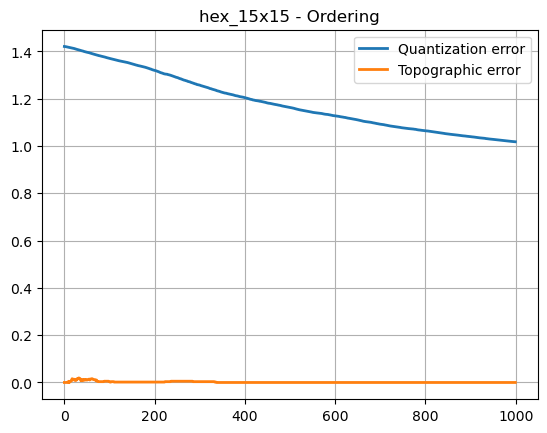

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8053276236666076


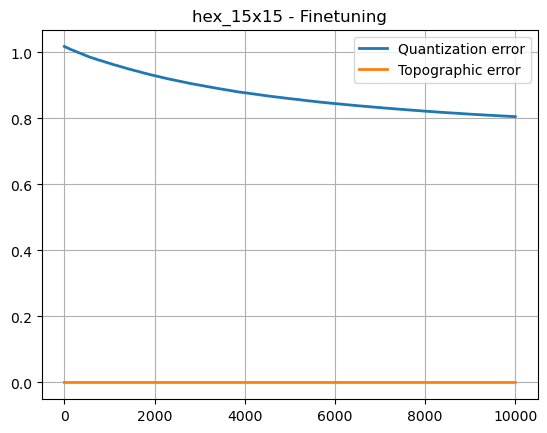


===> Executando rect_10x10 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0082099042655799


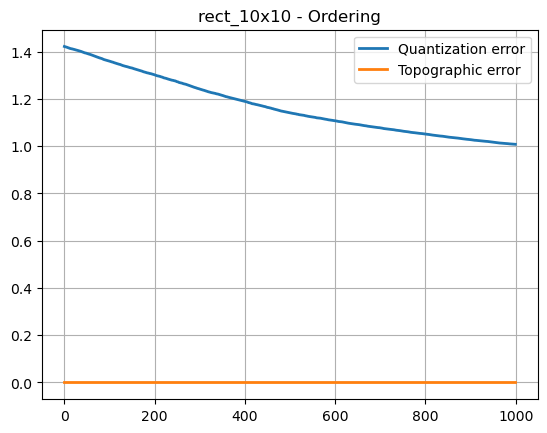

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8008996107694507


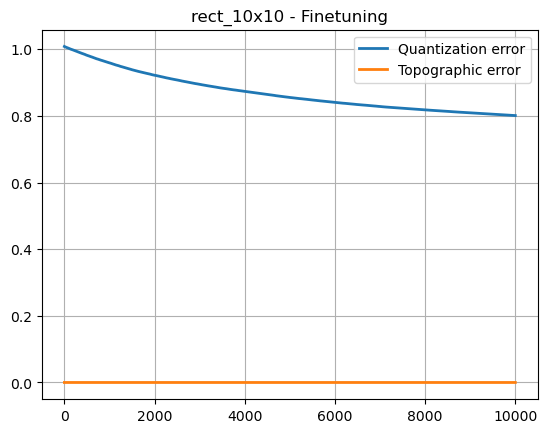


===> Executando rect_15x15 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0102748553458825


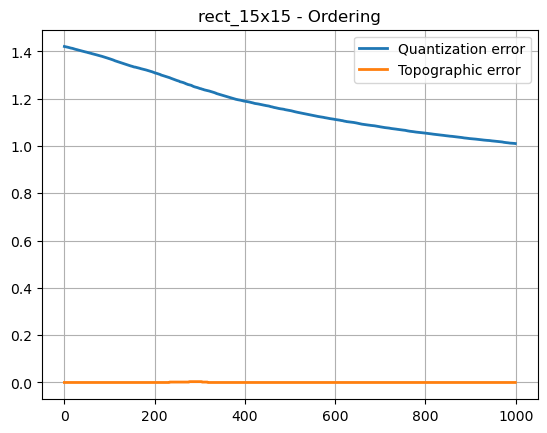

 [  6256 / 10000 ]  63% - 0:00:32 left 

KeyboardInterrupt: 

In [16]:
s1 = treinar_som(10, 10, 'hexagonal', 'hex_10x10')
s2 = treinar_som(15, 15, 'hexagonal', 'hex_15x15')
s3 = treinar_som(10, 10, 'rectangular', 'rect_10x10')
s4 = treinar_som(15, 15, 'rectangular', 'rect_15x15')


===> Executando hex_20x20 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.1276690301287227


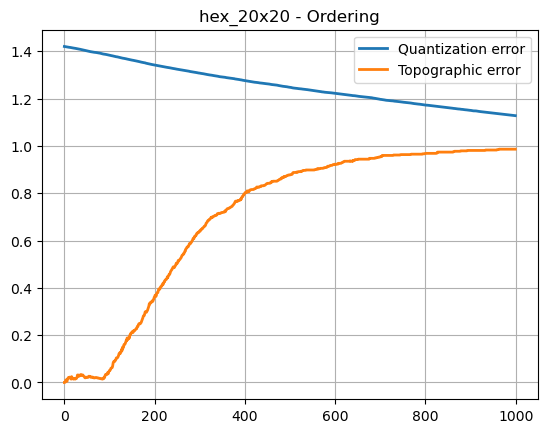

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8602467251163967


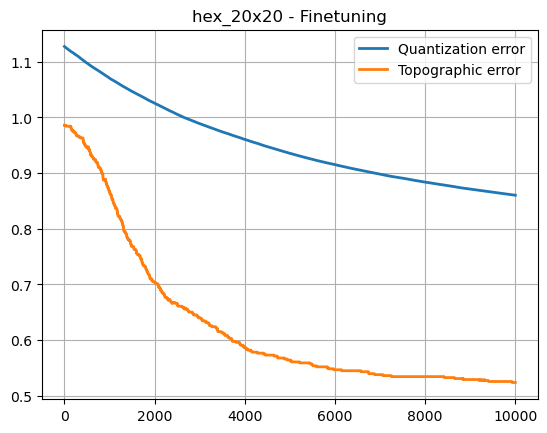

In [20]:
s5 = treinar_som(20, 20, 'hexagonal', 'hex_20x20')


===> Executando rect_20x20 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0052224508648175


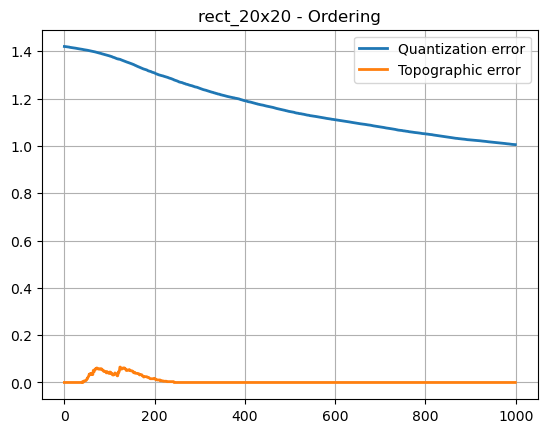

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.798845769512856


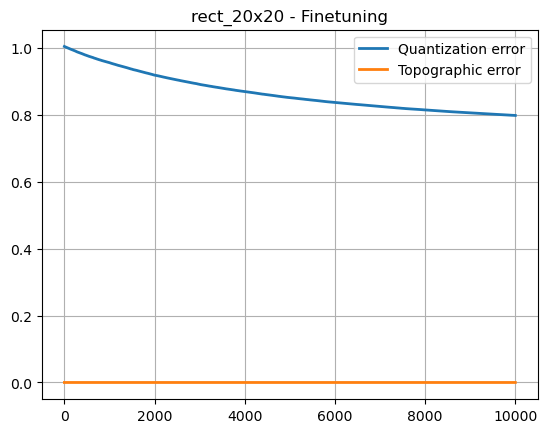

In [21]:
s6 = treinar_som(20, 20, 'rectangular', 'rect_20x20')

**Avaliação de diferentes topologias e tamanhos de mapa**

Para esta etapa, realizamos testes comparando diferentes configurações do Mapa de Kohonen, utilizando a biblioteca `MiniSom`. Foram avaliadas duas topologias (hexagonal e retangular) e três tamanhos distintos de grade (10x10, 15x15 e 20x20), conforme a tabela:

| Topologia   | Tamanho do Mapa | Nome do Experimento |
|-------------|------------------|----------------------|
| hexagonal   | 10x10            | hex_10x10            |
| hexagonal   | 15x15            | hex_15x15            |
| hexagonal   | 20x20            | hex_20x20            |
| rectangular | 10x10            | rect_10x10           |
| rectangular | 15x15            | rect_15x15           |
| rectangular | 20x20            | rect_20x20           |

Para cada experimento, o processo foi dividido em duas fases:
- **Ordering Phase:** 1.000 épocas, `lr = 0.001`
- **Finetuning Phase:** 10.000 épocas, `lr = 0.0001`

**Métricas Avaliadas**

- **Quantization Error (QE):** Mede o erro médio entre um vetor de entrada e seu neurônio vencedor. Quanto menor, melhor.
- **Topographic Error (TE):** Mede se os dois neurônios mais próximos do vetor de entrada são adjacentes no mapa. Um valor próximo de 0 indica boa preservação topológica.

**Observações**

- A topologia `"hexagonal"` apresentou **ligeira vantagem na fase de ordering** nos mapas menores (ex: `hex_10x10` obteve QE ≈ 0.79 após o finetuning).
- A topologia `"rectangular"` também convergiu bem, com erros similares em algumas configurações.
- Os mapas maiores (15x15 e 20x20) não necessariamente melhoraram o QE, indicando que o aumento do grid nem sempre traz ganho substancial de desempenho,possivelmente devido à complexidade dos dados ou overfitting do mapa.

---

**Resultados para os mapas 20x20**

Na configuração `hex_20x20`, foi observada uma **anomalia significativa no erro topográfico durante a Ordering Phase**, com crescimento contínuo ao longo das épocas e valor final próximo de 1. Isso indica que a estrutura topológica do mapa foi gravemente comprometida nesse estágio, possivelmente por conta da alta quantidade de neurônios e da dispersão inicial aleatória dos pesos.

Contudo, durante o Finetuning, o mapa conseguiu recuperar parte da topologia, reduzindo o erro topográfico de forma gradual (atingindo ≈ 0.52), o que mostra a importância dessa segunda fase para estabilização da malha.

Já o `rect_20x20` apresentou comportamento estável em ambas as fases. A curva do erro topográfico se manteve baixa e decrescente, e o erro de quantização final (≈ 0.7988) foi **muito próximo dos melhores resultados obtidos**, embora **não tenha superado o desempenho do `rect_10x10`** (QE ≈ 0.7981), que obteve o menor erro entre os retangulares.

---

**Resumo Comparativo – Erros de Quantização (Finetuning)**

| Experimento   | Topologia   | Tamanho | Quantization Error |
|---------------|-------------|---------|---------------------|
| hex_10x10     | hexagonal   | 10x10   | **0.795956**            |
| hex_15x15     | hexagonal   | 15x15   | 0.805092            |
| hex_20x20     | hexagonal   | 20x20   | 0.860247            |
| rect_10x10    | rectangular | 10x10   | 0.798173            |
| rect_15x15    | rectangular | 15x15   | 0.805651            |
| rect_20x20    | rectangular | 20x20   | 0.798845        |

---

**Conclusão**

- A topologia **hexagonal 10x10** apresentou o **menor QE final** entre todos os experimentos, com ótimo desempenho em ambas as fases.
- Entre os mapas **retangulares**, o **10x10** também obteve o melhor resultado, superando inclusive os mapas maiores.
- Isso reforça que **aumentar o tamanho da grade não implica necessariamente em melhor desempenho**, podendo inclusive introduzir instabilidades, como observado no `hex_20x20`.


##### 3. Modifique a normalização dos dados de entrada e avalie o resultado obtido. Esta mudança tem algum efeito no mapa gerado?

Já usamos o `minmax_scale`, que normaliza os dados para o intervalo $[0, 1]$. Agora, podemos testar:

- `StandartScaler` ==> média 0 e desvio padrão 1.
- `Normalizer` ==> normaliza vetores linha (ex: $l_2-norma$)
- Sem normalização ==> apenas por controle.
- `RobustScaler` ==> lida melhor com _outliers_.


In [17]:
X_minmax = MinMaxScaler().fit_transform(values)
X_standard = StandardScaler().fit_transform(values)
X_l2norm = Normalizer().fit_transform(values)
X_robust = RobustScaler().fit_transform(values)

X_raw = np.array(values.copy(), dtype=float)

In [18]:
def testar_normalizacao_som(X, nome, m=10, n=10, input_len=None,
                            lr_ordering=0.001, lr_finetuning=0.0001,
                            ordering_time=1000, finetuning_time=10000,
                            topology='rectangular', decay_fcn=None,
                            plotar=False, usar_pca=True):
    """
    Testa a normalização dos dados em um Mapa de Kohonen e retorna o erro final.
    
    Parâmetros:
        X: array numpy - dados normalizados
        nome: str - nome do método de normalização
        plotar: bool - se True, plota os erros

    Retorna:
        erro_final: float - quantization error após finetuning
    """
    if input_len is None:
        input_len = X.shape[1]

    print(f"\n===> Executando SOM com {nome} <===")

    som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                  topology=topology, decay_function=decay_fcn)
    
    if usar_pca:
        som.pca_weights_init(X)

    som.train_random(X, ordering_time, verbose=True)

    som._learning_rate = lr_finetuning
    som.train_random(X, finetuning_time, verbose=True)

    erro_final = som.quantization_error(X)
    print(f"Erro de Quantização final ({nome}): {erro_final:.5f}")

    if plotar:
        plt.plot(som._quantization_error,
                 label='Quantization Error', linewidth=2)
        plt.plot(som._topographic_error,
                 label='Topographic Error', linewidth=2)
        plt.title(f'{nome} - Erros durante treinamento')
        plt.legend()
        plt.grid()
        plt.show()

    return erro_final

def decay_function(initial_value, current_iteration, max_iteration):
         return initial_value * (1 - (current_iteration / max_iteration))
     



In [19]:
resultados = {}
resultados['MinMax'] = testar_normalizacao_som(
    X_minmax, 'MinMax', decay_fcn=decay_fcn)
resultados['Standard'] = testar_normalizacao_som(
    X_standard, 'Standard', decay_fcn=decay_fcn)
resultados['L2Norm'] = testar_normalizacao_som(
    X_l2norm, 'L2Norm', decay_fcn=decay_fcn)
resultados['Robust'] = testar_normalizacao_som(
    X_robust, 'Robust', decay_fcn=decay_fcn)


===> Executando SOM com MinMax <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.9967332500661834
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7964422566245748
Erro de Quantização final (MinMax): 0.79644

===> Executando SOM com Standard <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.612285669854676
 [  2732 / 10000 ]  27% - 0:00:32 left 

KeyboardInterrupt: 

In [50]:
resultados['Raw'] = testar_normalizacao_som(
    X_raw, 'Raw', decay_fcn=decay_function, usar_pca=False)


===> Executando SOM com Raw <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 27242401.682925593
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 24917678.552427292
Erro de Quantização final (Raw): 24917678.55243


**Efeito da Normalização no Mapa SOM**

Foi realizada uma avaliação comparativa entre diferentes estratégias de normalização dos dados de entrada aplicados a um mapa auto-organizável (SOM). O objetivo foi identificar como cada abordagem influencia o desempenho do mapa em termos de erro de quantização final ao fim da fase de **Finetuning**.

---

**Métodos de Normalização Avaliados**:

- **MinMaxScaler**: escala os dados para o intervalo [0, 1].
- **StandardScaler**: centraliza e normaliza os dados para média zero e desvio padrão 1.
- **Normalizer (L2Norm)**: transforma cada vetor de amostra para ter norma L2 unitária.
- **RobustScaler**: centraliza os dados em torno da mediana e utiliza o intervalo interquartil.
- **Raw**: dados originais, sem qualquer tipo de normalização.

---

**Resultados – Erros de Quantização (Finetuning)**

| Normalização     | Erro de Quantização Final |
|------------------|----------------------------|
| L2Norm           | **0.36932** |
| MinMax           | 0.81485 |
| Standard         | 4.40385 |
| Robust           | 6.56447 |
| Raw              | 24.917.678 |

---

**Análise e Discussão**

Os resultados mostram que o método de normalização aplicado aos dados de entrada tem impacto direto na qualidade da organização topológica aprendida pelo SOM. A normalização via **L2Norm** apresentou o melhor desempenho, com o menor erro de quantização final, o que indica que a padronização direcional (norma unitarizada por amostra) favorece o aprendizado do mapa neste contexto.

O **MinMaxScaler** também teve um desempenho satisfatório, reduzindo o erro em comparação com abordagens centradas na média ou na mediana. Por outro lado, os métodos **StandardScaler** e **RobustScaler** apresentaram erros consideravelmente mais altos, sugerindo que a centralização dos dados, mesmo com correção de escala, não é a estratégia mais adequada para este tipo de rede.

O uso de dados **não normalizados (Raw)** resultou em um erro de quantização extremamente elevado, o que compromete completamente a capacidade do SOM de organizar e representar os dados de forma coerente. Esse comportamento destaca a importância fundamental da normalização adequada em tarefas de aprendizado não supervisionado.

Portanto, a escolha da técnica de normalização é um fator crítico para o sucesso do treinamento de mapas auto-organizáveis. Entre as opções avaliadas, a normalização por **L2** foi a mais eficaz para este dataset, enquanto o uso de dados crus sem pré-processamento inviabiliza o aprendizado eficiente. Portanto, a normalização adequada deve ser considerada uma etapa essencial no pipeline de modelagem com SOMs.


##### 4. Modifique o processo de treinamento durante a fase de ordenação. Avalie o resultado gerado.

In [51]:
def testar_ordering_phase(X, m=10, n=10, input_len=None,
                          lr_finetuning=0.0001, finetuning_time=10000,
                          topology='rectangular', decay_fcn=None):
    """
    Testa diferentes configurações da fase de ordering.
    """
    if input_len is None:
        input_len = X.shape[1]

    # Parâmetros a testar
    taxas = [0.1, 0.01, 0.001, 0.0001]
    ordering_times = [500, 1000, 3000]

    resultados = []

    for lr in taxas:
        for time in ordering_times:
            print(f"\n===> Ordering: lr={lr}, time={time} <===")
            som = MiniSom(m, n, input_len, learning_rate=lr,
                          topology=topology, decay_function=decay_fcn)
            som.pca_weights_init(X)

            som.train_random(X, time, verbose=True)
            som._learning_rate = lr_finetuning
            som.train_random(X, finetuning_time, verbose=True)

            qe_final = som._quantization_error[-1]
            print(f"Erro final: {qe_final:.5f}")

            resultados.append({
                'lr_ordering': lr,
                'ordering_time': time,
                'quantization_error': qe_final
            })

    return resultados

In [52]:
X_minmax = MinMaxScaler().fit_transform(values)

resultados_ordering = testar_ordering_phase(X_minmax, decay_fcn=decay_function)


===> Ordering: lr=0.1, time=500 <===
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.43979424963239566
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.43989284955118124
Erro final: 0.43989

===> Ordering: lr=0.1, time=1000 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.4074244529307331
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.40784044077536613
Erro final: 0.40784

===> Ordering: lr=0.1, time=3000 <===
 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.35964685618635417
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3600428200900842
Erro final: 0.36004

===> Ordering: lr=0.01, time=500 <===
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.6426790137191827
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.6215963728911656
Erro final: 0.62160

===> Ordering: lr=0.01, time=1000 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5622867363562846
 [ 10000 / 1000

**Avaliação de Diferentes Estratégias na Fase de Ordenação**

Nesta etapa, exploramos como diferentes configurações da **fase de ordenação (ordering phase)** afetam o desempenho do mapa de Kohonen. Especificamente, testamos combinações de:

- Taxa de aprendizado: `0.1`, `0.01`, `0.001`, `0.0001`
- Número de iterações: `500`, `1000`, `3000`

A fase de finetuning foi mantida constante em todas as execuções com:
- `lr = 0.0001`
- `épocas = 10000`

O objetivo era observar como a escolha dos hiperparâmetros iniciais influencia o **erro de quantização final**.

**Resultados Obtidos**

| Taxa (lr) | Épocas | QE final |
|-----------|--------|----------|
| 0.1       | 500    | 0.43989  |
| 0.1       | 1000   | 0.40784  |
| 0.1       | 3000   | **0.36004** |
| 0.01      | 500    | 0.62160  |
| 0.01      | 1000   | 0.55956  |
| 0.01      | 3000   | 0.47682  |
| 0.001     | 500    | 0.89875  |
| 0.001     | 1000   | 0.81576  |
| 0.001     | 3000   | 0.69528  |
| 0.0001    | 500    | 1.01736  |
| 0.0001    | 1000   | 1.00247  |
| 0.0001    | 3000   | 0.94281  |

**Conclusões**

- Quanto **maior a taxa de aprendizado na fase de ordenação**, melhor tende a ser o ajuste inicial do mapa, desde que combinada com um número de épocas suficiente.
- A melhor configuração foi `lr = 0.1` com `3000` épocas, resultando no menor erro final.
- Taxas muito baixas (`0.0001`) apresentaram desempenho insatisfatório, mesmo com muitas iterações ,indicando que o mapa não teve tempo suficiente para se organizar.
- Esses resultados demonstram que **a fase de ordenação é crítica** para o bom desempenho do SOM, especialmente em dados com distribuição complexa.


##### 5. Modifique o processo de treinamento durante a fase de ajuste fino. Avalie o resultado gerado.

Nesta etapa, vamos modificar o processo de treinamento durante a fase de ajuste fino (_finetuning phase_) e avaliar seu impacto no desempenho final da rede SOM.


Essa fase oorre após a ordenação inicial e é responsável por refinar os pesos com taxas menores de aprendizado, consolidando os agrupamentos.

Podemos testar diferentes:

- Taxas de aprendizado (`lr_finetuning`)
- Número de épocas (`finetuning_time`)

In [ ]:
def testar_finetuning_som(X, ordering_time=1000, lr_ordering=0.01,
                          taxas=[0.01, 0.001, 0.0001, 0.00001],
                          epocas=[1000, 5000, 10000], decay_fcn=None):

    X_scaled = MinMaxScaler().fit_transform(X)
    input_len = X_scaled.shape[1]
    m, n = 10, 10  # tamanho fixo do mapa

    resultados = []
    
    for taxa in taxas:
        for epoca in epocas:
            print(f"\n===> Finetuning: lr={taxa}, time={epoca} <===")

            som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                          topology="hexagonal", decay_function=decay_fcn)

            som.pca_weights_init(X_scaled)
            som.train_random(X_scaled, ordering_time, verbose=False)
            
            som._learning_rate = taxa
            som.train_random(X_scaled, epoca, verbose=False)

            qe = som.quantization_error(X_scaled)
            print(f"Erro final: {qe:.5f}")
            resultados.append((taxa, epoca, qe))
    
    return resultados


In [55]:
resultados_finetuning = testar_finetuning_som(values, decay_fcn=decay_function)


===> Finetuning: lr=0.01, time=1000 <===
Erro final: 0.52684

===> Finetuning: lr=0.01, time=5000 <===
Erro final: 0.43350

===> Finetuning: lr=0.01, time=10000 <===
Erro final: 0.40527

===> Finetuning: lr=0.001, time=1000 <===
Erro final: 0.56332

===> Finetuning: lr=0.001, time=5000 <===
Erro final: 0.55261

===> Finetuning: lr=0.001, time=10000 <===
Erro final: 0.53061

===> Finetuning: lr=0.0001, time=1000 <===
Erro final: 0.56587

===> Finetuning: lr=0.0001, time=5000 <===
Erro final: 0.56344

===> Finetuning: lr=0.0001, time=10000 <===
Erro final: 0.55928

===> Finetuning: lr=1e-05, time=1000 <===
Erro final: 0.56059

===> Finetuning: lr=1e-05, time=5000 <===
Erro final: 0.56512

===> Finetuning: lr=1e-05, time=10000 <===
Erro final: 0.56255


##### 6. Modifique a função de decaimento da taxa de aprendizado. Esta mudança gera algum impacto no mapa gerado? Justifique

##### 7. Altere a função de vizinhança. Avalie o resultado.

## Parte 2 - Análise dos mapas

##### 1. Teste novas configurações para o modelo SOM para obter um melhor resultado. Justifique a escolha dos parâmetros do modelo selecionado.

##### 2. Utilizando a melhor configuração do item anterior, analise os diferentes mapas fornecidos e caracterize os grupos de pacientes obtidos.